In [1]:
# Initialize modules
import pandas as pd
import numpy as np
import censusdata
import matplotlib.pyplot as plt
from sodapy import Socrata
pd.set_option('display.precision', 2)

# Load Census Data from US Census Bureau
censustable = censusdata.download('acs5', 2019, censusdata.censusgeo([('state', '06'), \
                        ('county', '085'), ('tract', '*')]), ['B03001_001E', 'B03001_003E'])
censustable['Percent Hispanic'] = censustable['B03001_003E'].div(censustable['B03001_001E'])*100
censusdata.export.exportcsv("census.csv", censustable)
census= pd.read_csv('census.csv')

# Load Covid-19 data from the County of Santa Clara
client = Socrata("data.sccgov.org", None)
# Get Covid-19 Case Rate by Tract data
results = client.get("can9-fquj", limit=2000)
# Convert to pandas DataFrame
covidcases = pd.DataFrame.from_records(results)
# Get Covid-19 Positivity Rate by Tract data
results2 = client.get("kbj4-a63r", limit=2000)
# Convert to pandas DataFrame
covidpos = pd.DataFrame.from_records(results2)
# Get Covid-19 Vax data
results3 = client.get("8vv7-38uc", limit=2000)
# Convert to pandas DataFrame
vaxrate = pd.DataFrame.from_records(results3)
# Get Covid-19 Test data
results4 = client.get("qnke-t7h7", limit=2000)
# Convert to pandas DataFrame
testrate = pd.DataFrame.from_records(results4)
# Convert tract numbers
covidcases['tract'] = pd.to_numeric(covidcases['tract']) - 6085000000
covidpos['tract'] = pd.to_numeric(covidpos['tract']) - 6085000000
vaxrate['tract'] = pd.to_numeric(vaxrate['tract']) - 0
testrate['tract'] = pd.to_numeric(testrate['tract']) - 6085000000

# Merge and tidy datasets
newone = pd.merge(left=covidpos, right=covidcases, left_on="tract", right_on="tract")
newone['caserate'] = pd.to_numeric(newone['case_rate']) / 1000
newerone = newone[{'tract', 'caserate', 'pos_rate'}]
newertwo = pd.merge(left=newerone, right=census, left_on="tract", right_on="tract")
newertwo = newertwo.drop(columns=['state', 'county', 'NAME', 'B03001_001E', 'B03001_003E'])
newertwo['vaxrate'] = pd.to_numeric(vaxrate['vacc12_count']) / pd.to_numeric(vaxrate['popu_12']) * 100
newertwo['testrate'] = pd.to_numeric(testrate['test_rate']) / 1000
# Number rows
newertwo['row_num'] = np.arange(len(newertwo['tract']))

# Subroutine finished
print("Dataframe initialized.")

Dataframe initialized.


<Figure size 3900x1800 with 0 Axes>

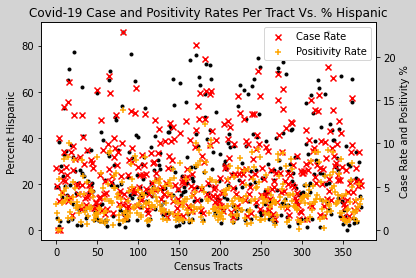

In [2]:
# Define plotdata() function
def plotdata(framename):
  plt.figure(figsize=(13, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent Hispanic'])
  ax.scatter(x, y, marker='.', color='black', label="Percent Hispanic")
  plt.ylabel('Percent Hispanic')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Case and Positivity Rates Per Tract Vs. % Hispanic') 
  ax2=ax.twinx()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['caserate'])
  ax2.scatter(x, y, marker='x', color='red', label="Case Rate")
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['pos_rate'])
  ax2.scatter(x, y, marker='+', color='orange', label="Positivity Rate")
  plt.ylabel('Case Rate and Positivity %')
  plt.legend()
  fig.patch.set_facecolor('lightgray')
 

# Clean dataframes
newertwo['pos_rate'].fillna(value=0, inplace=True)
newertwo['caserate'].fillna(value=0, inplace=True)

# Plot unsorted data
plotdata(newertwo)
plt.savefig('figure1.svg')

<Figure size 3900x1800 with 0 Axes>

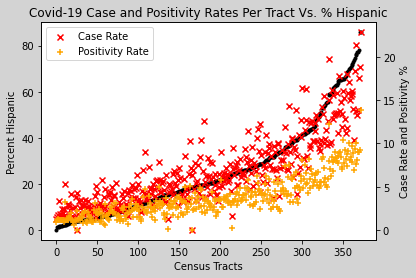

In [3]:
# Sort tracts by "Percent Hispanic"
newerthree = newertwo.sort_values(by=['Percent Hispanic'], axis=0, inplace=False)
newerthree['row_num'] = np.arange(len(newerthree['tract']))

# Plot sorted data
plotdata(newerthree)
plt.savefig('figure2.svg')

<Figure size 3900x1800 with 0 Axes>

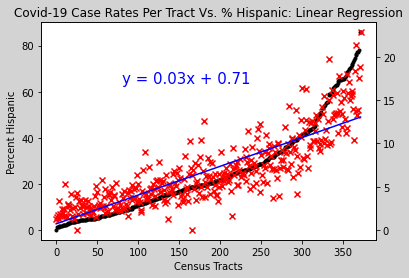

In [7]:
# Import linregress
from scipy.stats import linregress
  
def plotdata(framename):
  plt.figure(figsize=(13, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent Hispanic'])
  ax.scatter(x, y, marker='.', color='black', label="Percent Hispanic")
  plt.ylabel('Percent Hispanic')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Case Rates Per Tract Vs. % Hispanic: Linear Regression') 
  ax2=ax.twinx()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['caserate'])
  ax2.scatter(x, y, marker='x', color='red', label="Case Rate")
  (slope, intercept, r_value, p_value, std_err) = linregress(x, y)
  line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Calculate the regression line "y values" from the slope and intercept.
  regress_values = x * slope + intercept
  plt.plot(x,regress_values,"b")
  plt.annotate(line_eq, (80,17), fontsize=15, color="blue")
  fig.patch.set_facecolor('lightgray')
  (slope, intercept, r_value, p_value, std_err) = linregress(x, y)

# Sort tracts by "Percent White Only"
newerthree = newertwo.sort_values(by=['Percent Hispanic'], axis=0, inplace=False)
newerthree['row_num'] = np.arange(len(newerthree['tract']))

# Plot sorted data
plotdata(newerthree)
plt.savefig('figure2ha.svg')
plt.show()

<Figure size 3900x1800 with 0 Axes>

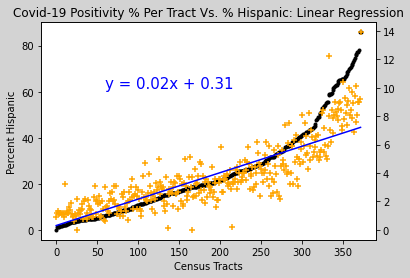

In [8]:
def plotdata(framename):
  plt.figure(figsize=(13, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent Hispanic'])
  ax.scatter(x, y, marker='.', color='black', label="Percent Hispanic")
  plt.ylabel('Percent Hispanic')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Positivity % Per Tract Vs. % Hispanic: Linear Regression') 
  ax2=ax.twinx()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['pos_rate'])
  ax2.scatter(x, y, marker='+', color='orange', label="Positivity Rate")
  (slope, intercept, r_value, p_value, std_err) = linregress(x, y)
  line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Calculate the regression line "y values" from the slope and intercept.
  regress_values = x * slope + intercept
  plt.plot(x,regress_values,"b")
  plt.annotate(line_eq, (59,10), fontsize=15, color="blue")
  fig.patch.set_facecolor('lightgray')

# Sort tracts by "Percent White Only"
newerthree = newertwo.sort_values(by=['Percent Hispanic'], axis=0, inplace=False)
newerthree['row_num'] = np.arange(len(newerthree['tract']))

# Plot sorted data
plotdata(newerthree)
plt.savefig('figure2hb.svg')
plt.show()

<Figure size 3600x1800 with 0 Axes>

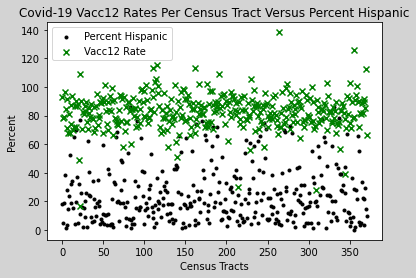

In [4]:
# Define plotdata() function
def plotvax(framename):
  plt.figure(figsize=(12, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent Hispanic'])
  ax.scatter(x, y, marker='.', color='black', label="Percent Hispanic")
  plt.ylabel('Percent')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Vacc12 Rates Per Census Tract Versus Percent Hispanic') 
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['vaxrate'])
  ax.scatter(x, y, marker='x', color='green', label="Vacc12 Rate")
  plt.legend()
  fig.patch.set_facecolor('lightgray')

plotvax(newertwo)
plt.savefig('figure3.svg')

In [10]:
newerfour = newertwo.sort_values(by=['Percent Hispanic'], axis=0, inplace=False)
newerfour['row_num'] = np.arange(len(newerthree['tract']))
plotvax(newerfour)
plt.savefig('figure4.svg')

NameError: name 'plotvax' is not defined

-3.910183724666591e-06 84.11082329298655


<Figure size 3900x1800 with 0 Axes>

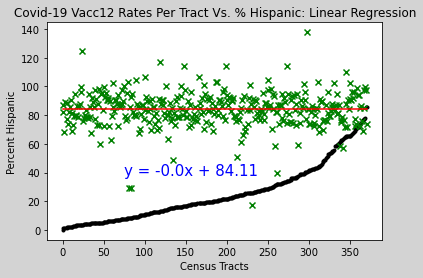

In [15]:
def plotdata(framename):
  framename.dropna(inplace=True)
  plt.figure(figsize=(13, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'].reset_index(drop=True))
  y = pd.to_numeric(framename['Percent Hispanic'].reset_index(drop=True))
  ax.scatter(x, y, marker='.', color='black', label="Percent Hispanic")
  plt.ylabel('Percent Hispanic')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Vacc12 Rates Per Tract Vs. % Hispanic: Linear Regression') 
  y2 = pd.to_numeric(framename['vaxrate'].reset_index(drop=True))
  ax.scatter(x, y2, marker='x', color='green', label="Vacc12 Rate")
  m, b = np.polyfit(x, y2, 1)
  print(m,b)
  plt.plot(x, m*x + b, c="r")
  line_eq = "y = " + str(round(m,2)) + "x + " + str(round(b,2))
  plt.annotate(line_eq, (75,38), fontsize=15, color="blue")
  fig.patch.set_facecolor('lightgray')


# Plot sorted data
plotdata(newerfour)
plt.savefig('figure4ha.svg')
plt.show()

<Figure size 3600x1800 with 0 Axes>

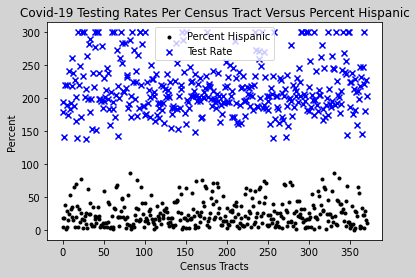

In [16]:
# Define plottest() function
def plottest(framename):
  plt.figure(figsize=(12, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent Hispanic'])
  ax.scatter(x, y, marker='.', color='black', label="Percent Hispanic")
  plt.ylabel('Percent')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Testing Rates Per Census Tract Versus Percent Hispanic') 
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['testrate'])
  ax.scatter(x, y, marker='x', color='blue', label="Test Rate")
  plt.legend()
  fig.patch.set_facecolor('lightgray')

newertwo['testrate'].values[newertwo['testrate'].values > 300] = 300
plottest(newertwo)
plt.savefig('figure5.svg')

<Figure size 3600x1800 with 0 Axes>

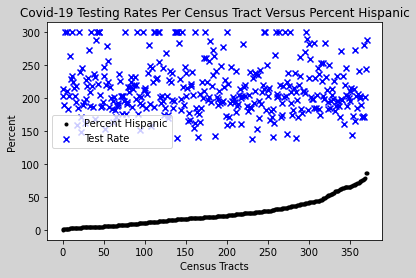

In [17]:

newerfive = newertwo.sort_values(by=['Percent Hispanic'], axis=0, inplace=False)
newerfive['row_num'] = np.arange(len(newerfive['tract']))
plottest(newerfive)
plt.savefig('figure6.svg')

<Figure size 3900x1800 with 0 Axes>

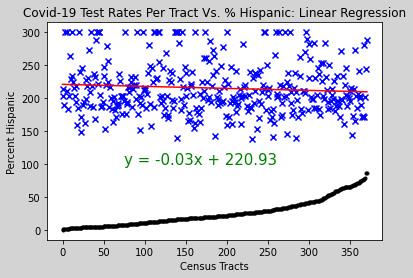

In [19]:
def plotreg(framename):
  framename.dropna(inplace=True)
  plt.figure(figsize=(13, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'].reset_index(drop=True))
  y = pd.to_numeric(framename['Percent Hispanic'].reset_index(drop=True))
  ax.scatter(x, y, marker='.', color='black', label="Percent Hispanic")
  plt.ylabel('Percent Hispanic')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Test Rates Per Tract Vs. % Hispanic: Linear Regression') 
  y2 = pd.to_numeric(framename['testrate'].reset_index(drop=True))
  ax.scatter(x, y2, marker='x', color='blue', label="Test Rate")
  m, b = np.polyfit(x, y2, 1)
  plt.plot(x, m*x + b, c="r")
  line_eq = "y = " + str(round(m,2)) + "x + " + str(round(b,2))
  plt.annotate(line_eq, (75,100), fontsize=15, color="green")
  fig.patch.set_facecolor('lightgray')

#remove outliers
newerfive['testrate'].values[newerfive['testrate'].values > 300] = 300

# Plot sorted data
plotreg(newerfive)
plt.savefig('figure6ha.svg')
plt.show()